# AATau Photometry

In [1]:
import numpy as np
import tarfile
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from sys import platform
from astropy.io import fits
from astropy.io import ascii
from astropy import units as u
import astropy.table as Table
from astropy.table import QTable
from dust_extinction.parameter_averages import F99
from synphot import units
from synphot import SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D,Empirical1D

In [2]:
# %matplotlib notebook  
%matplotlib inline

Read in data files reduced by earlier notebook:

In [3]:
data1 = ascii.read('AATau_IR2008.txt')
data2 = ascii.read('AATau_opt2008.txt')
data = Table.vstack([data2, data1])
allwav_2008=data['wavelength']
alldata_2008=data['flux']

data1 = ascii.read('AATau_IR2014dec02.txt')
data2 = ascii.read('AATau_opt2014dec02.txt')
data = Table.vstack([data2, data1])
allwav_dec02=data['wavelength']
alldata_dec02=data['flux']

data1 = ascii.read('AATau_IR2014dec12.txt')
data2 = ascii.read('AATau_opt2014dec12.txt')
data = Table.vstack([data2, data1])
allwav_dec12=data['wavelength']
alldata_dec12=data['flux']

Make an interpolation function to divide one spectrum by the other:

In [4]:
interp2008=interp.interp1d(allwav_2008,alldata_2008)

The overlaps in the spectra are not tolerated by synphot, so we sort them:

In [5]:
allwav_2008s=allwav_2008[np.argsort(allwav_2008)]
alldata_2008s=alldata_2008[np.argsort(allwav_2008)]

allwav_dec02s=allwav_dec02[np.argsort(allwav_dec02)]
alldata_dec02s=alldata_dec02[np.argsort(allwav_dec02)]

allwav_dec12s=allwav_dec12[np.argsort(allwav_dec12)]
alldata_dec12s=alldata_dec12[np.argsort(allwav_dec12)]

# By coincidence, some wavelengths are identical, so we nudge them a bit:
# WARNING!  HARD WIRED!
allwav_dec02s[2405]=np.float32(0.934964)*u.micron
allwav_dec12s[2166]=np.float32(0.913868)*u.micron
allwav_dec12s[2484]=np.float32(0.941703)*u.micron

In [6]:
# Optional, for when the STScI ftp server is not answering:
from synphot import config
config.conf.vega_file='http://ssb.stsci.edu/cdbs/calspec/alpha_lyr_stis_008.fits'
config.conf.johnson_u_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_u_004_syn.fits'
config.conf.johnson_b_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_b_004_syn.fits'
config.conf.johnson_v_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_v_004_syn.fits'
config.conf.johnson_r_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_r_003_syn.fits'
config.conf.johnson_i_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_i_003_syn.fits'
config.conf.bessel_j_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_j_003_syn.fits'
config.conf.bessel_h_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_h_004_syn.fits'
config.conf.bessel_k_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_k_003_syn.fits'

vega = SourceSpectrum.from_vega()
u_band = SpectralElement.from_filter('johnson_u')
b_band = SpectralElement.from_filter('johnson_b')
v_band = SpectralElement.from_filter('johnson_v')
r_band = SpectralElement.from_filter('johnson_r')
i_band = SpectralElement.from_filter('johnson_i')
j_band = SpectralElement.from_filter('bessel_j')
h_band = SpectralElement.from_filter('bessel_h')
k_band = SpectralElement.from_filter('bessel_k')


Create synthetic spectra with the FMUNRED model:

In [7]:
fobs1ext=dict()

j=0

for A in [2.0,4.0]:
    for R in [2.0,3.0,5.0]:
        ext=F99(Rv=R)
        fobs1ext[j]=alldata_2008s*ext.extinguish(allwav_2008s,Av=A)
        j+=1     

Calculate photometry of observed and synthetically extinguished spectra:

In [8]:
bands = [k_band,h_band,j_band,i_band,r_band,v_band,b_band]

mags1ext=np.zeros((6,7))

mags1=np.zeros(7)
mags2=np.zeros(7)
mags3=np.zeros(7)
mags4=np.zeros(7)

for j in [0,1,2,3,4,5,6]:
    sp = SourceSpectrum(Empirical1D, points=allwav_2008s, lookup_table=alldata_2008s, keep_neg=False)
    sp_obs = Observation(sp, bands[j])
    mags1[j]=sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value # default binned=False
    sp = SourceSpectrum(Empirical1D, points=allwav_dec02s, lookup_table=alldata_dec02s, keep_neg=False)
    sp_obs = Observation(sp, bands[j])
    mags2[j]=sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value
    sp = SourceSpectrum(Empirical1D, points=allwav_dec12s, lookup_table=alldata_dec12s, keep_neg=False)
    sp_obs = Observation(sp, bands[j])
    mags3[j]=sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value
    
    for i in range(6):
        sp = SourceSpectrum(Empirical1D, points=allwav_2008s, lookup_table=fobs1ext[i], keep_neg=False)
        sp_obs = Observation(sp, bands[j])
        mags1ext[i,j] = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value
    

  points: [13619.504 13621.229 13622.954 13624.678 13807.297 13809.017 13826.228
 13827.947 13924.257 18204.887 18264.535]
  lookup_table: [-0.06155703 -0.16120483 -0.2462627  -0.06569865 -0.03514313 -0.01424272
 -0.01983138 -0.03685726 -0.00325952 -0.02674026 -0.01405363] [synphot.models]
  points: [ 3303.44    3305.8198  3308.2     3312.96    3315.34    3317.72
  3327.24    3334.3801  3336.76    3339.1401  3341.52    3346.2798
  3353.42    3367.7     3370.08    3372.46    3374.84    3377.22
  3386.74    3389.12    3403.4     3405.7798  3408.16    3415.3
  3417.68    3422.44    3424.82    3429.58    3431.96    3450.9998
  3472.42    3515.26    3524.78    3534.3     3643.78    3646.1602
  3648.54   13610.7    13615.8    13617.601  13619.3    13621.
 13622.7    13624.5    13626.2    13645.199  13646.899  13648.601
 13676.2    13677.899  13679.6    13681.399  13683.1    13684.8
 13710.7    13805.4    13807.1    13808.8    13824.3    13825.999
 13827.699  13829.499  13881.101  13924.     

In [9]:
print("Date         B     V     R     I     J     H     K")
print("2008Dec28",np.round(mags1[::-1],2))
print("2014Dec02",np.round(mags2[::-1],2))
print("2014Dec12",np.round(mags3[::-1],2))

Date         B     V     R     I     J     H     K
2008Dec28 [13.99 12.85 11.57 10.54  9.48  8.64  8.13]
2014Dec02 [16.59 14.85 12.84 11.5  10.04  8.9   8.12]
2014Dec12 [16.18 14.95 12.95 11.61 10.07  8.92  8.11]


In [10]:
mags1

array([ 8.12545762,  8.63775381,  9.4796061 , 10.54233954, 11.57235532,
       12.84902046, 13.99366631])

In [11]:
mags2

array([ 8.1190166 ,  8.90018651, 10.03621318, 11.49856709, 12.84199828,
       14.84816432, 16.58947888])

In [12]:
mags3

array([ 8.11189694,  8.92168367, 10.07173608, 11.61187158, 12.95395126,
       14.94780733, 16.18287054])

In [13]:
mags1ext

array([[ 8.34920393,  8.98590141,  9.99722394, 11.32340427, 12.6551131 ,
        14.65587901, 16.74044124],
       [ 8.34196653,  8.96827834,  9.9944421 , 11.41831284, 12.82419083,
        14.72582521, 16.50511259],
       [ 8.33616823,  8.95416742,  9.9921507 , 11.49314381, 12.95895849,
        14.77624733, 16.3072267 ],
       [ 8.5726541 ,  9.33342211, 10.51339964, 12.09452271, 13.7034493 ,
        16.38573996, 19.36822833],
       [ 8.55824921,  9.29820724, 10.50705777, 12.27498226, 14.03625984,
        16.56566564, 18.96291505],
       [ 8.54670183,  9.27000966, 10.50173639, 12.41498897, 14.30036294,
        16.68845579, 18.6013921 ]])

I copy and paste into the figures file.  I'm not proud...

From Figures:

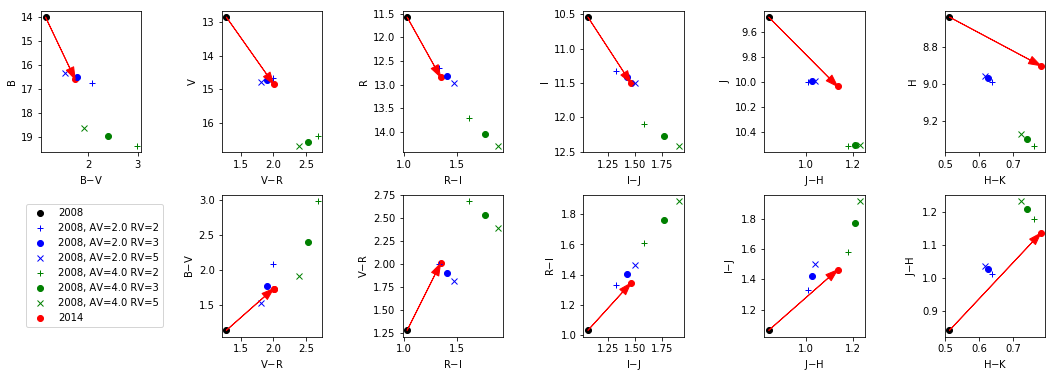

In [15]:
bands=['K','H','J','I','R','V','B']
mags
fig,axes=plt.subplots(2,6,figsize=(18,6))

for j in [0,1,2,3,4,5]: # just data
    if j!=5:
        axes[1,5-j].plot(mags2[j+1]-mags2[j],mags2[j+2]-mags2[j+1],'o',color='red')
        
        axes[1,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+2]-mags2[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1]),textcoords='data',
            arrowprops=dict(color='red',headwidth=8,headlength=12,width=0.1))
        
        axes[1,5-j].plot(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1],'o',color='black',label='2008')
        axes[1,5-j].set_xlabel(bands[j+1]+'$-$'+bands[j])
        axes[1,5-j].set_ylabel(bands[j+2]+'$-$'+bands[j+1])
                           
    axes[0,5-j].plot(mags1[j+1]-mags1[j],mags1[j+1],'o',color='black')
    axes[0,5-j].plot(mags2[j+1]-mags2[j],mags2[j+1],'o',color='red')
    axes[0,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+1]),textcoords='data',
            arrowprops=dict(color='red',headwidth=8,headlength=12,width=0.1))
    axes[0,5-j].set_xlabel(bands[j+1]+'$-$'+bands[j])
    axes[0,5-j].set_ylabel(bands[j+1])
    
for j in [0,1,2,3,4,5]: # extinction 
    if j!=5:
        axes[1,5-j].plot(mags1ext[0,j+1]-mags1ext[0,j],mags1ext[0,j+2]-mags1ext[0,j+1],'+',color='blue',label='2008, AV=2.0 RV=2')
        axes[1,5-j].plot(mags1ext[1,j+1]-mags1ext[1,j],mags1ext[1,j+2]-mags1ext[1,j+1],'o',color='blue',label='2008, AV=2.0 RV=3')
        axes[1,5-j].plot(mags1ext[2,j+1]-mags1ext[2,j],mags1ext[2,j+2]-mags1ext[2,j+1],'x',color='blue',label='2008, AV=2.0 RV=5')
        axes[1,5-j].plot(mags1ext[3,j+1]-mags1ext[3,j],mags1ext[3,j+2]-mags1ext[3,j+1],'+',color='green',label='2008, AV=4.0 RV=2')
        axes[1,5-j].plot(mags1ext[4,j+1]-mags1ext[4,j],mags1ext[4,j+2]-mags1ext[4,j+1],'o',color='green',label='2008, AV=4.0 RV=3')
        axes[1,5-j].plot(mags1ext[5,j+1]-mags1ext[5,j],mags1ext[5,j+2]-mags1ext[5,j+1],'x',color='green',label='2008, AV=4.0 RV=5')

    axes[0,5-j].plot(mags1ext[0,j+1]-mags1ext[0,j],mags1ext[0,j+1],'+',color='blue')
    axes[0,5-j].plot(mags1ext[1,j+1]-mags1ext[1,j],mags1ext[1,j+1],'o',color='blue')
    axes[0,5-j].plot(mags1ext[2,j+1]-mags1ext[2,j],mags1ext[2,j+1],'x',color='blue')
    axes[0,5-j].plot(mags1ext[3,j+1]-mags1ext[3,j],mags1ext[3,j+1],'+',color='green')
    axes[0,5-j].plot(mags1ext[4,j+1]-mags1ext[4,j],mags1ext[4,j+1],'o',color='green')
    axes[0,5-j].plot(mags1ext[5,j+1]-mags1ext[5,j],mags1ext[5,j+1],'x',color='green')
    
axes[1,1].plot(mags2[5]-mags2[4],mags2[6]-mags2[5],'o',color='red',label='2014') # just for the legend
axes[1,0].axis('off')
fig.subplots_adjust(wspace=0.8,hspace=0.3)
axes[1,1].legend(loc='center left', bbox_to_anchor=(-2, 0.5))
for j in [0,1,2,3,4,5]:
    axes[0,5-j].set_ylim(axes[0,5-j].get_ylim()[::-1])

# plt.savefig('fullcolormag.eps',bbox_inches='tight')
plt.show()

Now with the correction for veiling, redefine mags3:

In [110]:
# mags3 = mags2 - np.array([-0.5, -0.35, -0.25, 0, 0, 0, 0]) # 2014 w/o veiling relative to star, dimmer
mags3 = mags2 - np.array([-0.25, -0.1, -0.05, 0, 0, 0, 0]) # 2014 w/o veiling relative to 2008, dimmer

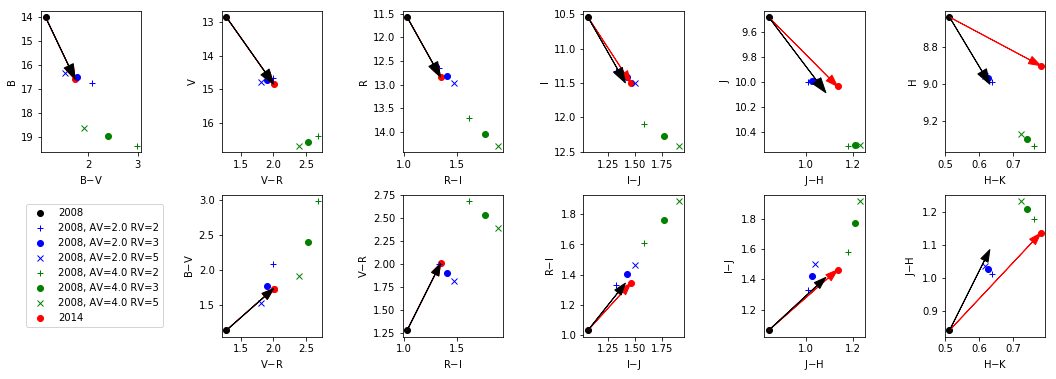

In [111]:
bands=['K','H','J','I','R','V','B']

fig,axes=plt.subplots(2,6,figsize=(18,6))

for j in [0,1,2,3,4,5]: # just data
    if j!=5:
        axes[1,5-j].plot(mags2[j+1]-mags2[j],mags2[j+2]-mags2[j+1],'o',color='red')
        axes[1,5-j].plot(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1],'o',color='black',label='2008')
        
        axes[1,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+2]-mags2[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1]),textcoords='data',
            arrowprops=dict(color='red',headwidth=8,headlength=12,width=0.1))

        axes[1,5-j].annotate("",xy=(mags3[j+1]-mags3[j],mags3[j+2]-mags3[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1]),textcoords='data',
            arrowprops=dict(color='black',headwidth=8,headlength=12,width=0.1))

    
        axes[1,5-j].set_xlabel(bands[j+1]+'$-$'+bands[j])
        axes[1,5-j].set_ylabel(bands[j+2]+'$-$'+bands[j+1])
                           
    axes[0,5-j].plot(mags1[j+1]-mags1[j],mags1[j+1],'o',color='black')
    axes[0,5-j].plot(mags2[j+1]-mags2[j],mags2[j+1],'o',color='red')
    
    axes[0,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+1]),textcoords='data',
            arrowprops=dict(color='red',headwidth=8,headlength=12,width=0.1))

    axes[0,5-j].annotate("",xy=(mags3[j+1]-mags3[j],mags3[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+1]),textcoords='data',
            arrowprops=dict(color='black',headwidth=10,headlength=15,width=0.1,linewidth=1))
     

    
    axes[0,5-j].set_xlabel(bands[j+1]+'$-$'+bands[j])
    axes[0,5-j].set_ylabel(bands[j+1])
    
for j in [0,1,2,3,4,5]: # extinction 
    if j!=5:
        axes[1,5-j].plot(mags1ext[0,j+1]-mags1ext[0,j],mags1ext[0,j+2]-mags1ext[0,j+1],'+',color='blue',label='2008, AV=2.0 RV=2')
        axes[1,5-j].plot(mags1ext[1,j+1]-mags1ext[1,j],mags1ext[1,j+2]-mags1ext[1,j+1],'o',color='blue',label='2008, AV=2.0 RV=3')
        axes[1,5-j].plot(mags1ext[2,j+1]-mags1ext[2,j],mags1ext[2,j+2]-mags1ext[2,j+1],'x',color='blue',label='2008, AV=2.0 RV=5')
        axes[1,5-j].plot(mags1ext[3,j+1]-mags1ext[3,j],mags1ext[3,j+2]-mags1ext[3,j+1],'+',color='green',label='2008, AV=4.0 RV=2')
        axes[1,5-j].plot(mags1ext[4,j+1]-mags1ext[4,j],mags1ext[4,j+2]-mags1ext[4,j+1],'o',color='green',label='2008, AV=4.0 RV=3')
        axes[1,5-j].plot(mags1ext[5,j+1]-mags1ext[5,j],mags1ext[5,j+2]-mags1ext[5,j+1],'x',color='green',label='2008, AV=4.0 RV=5')

    axes[0,5-j].plot(mags1ext[0,j+1]-mags1ext[0,j],mags1ext[0,j+1],'+',color='blue')
    axes[0,5-j].plot(mags1ext[1,j+1]-mags1ext[1,j],mags1ext[1,j+1],'o',color='blue')
    axes[0,5-j].plot(mags1ext[2,j+1]-mags1ext[2,j],mags1ext[2,j+1],'x',color='blue')
    axes[0,5-j].plot(mags1ext[3,j+1]-mags1ext[3,j],mags1ext[3,j+1],'+',color='green')
    axes[0,5-j].plot(mags1ext[4,j+1]-mags1ext[4,j],mags1ext[4,j+1],'o',color='green')
    axes[0,5-j].plot(mags1ext[5,j+1]-mags1ext[5,j],mags1ext[5,j+1],'x',color='green')
    
axes[1,1].plot(mags2[5]-mags2[4],mags2[6]-mags2[5],'o',color='red',label='2014') # just for the legend
axes[1,0].axis('off')
fig.subplots_adjust(wspace=0.8,hspace=0.3)
axes[1,1].legend(loc='center left', bbox_to_anchor=(-2, 0.5))
for j in [0,1,2,3,4,5]:
    axes[0,5-j].set_ylim(axes[0,5-j].get_ylim()[::-1])

# plt.savefig('fullcolormag.eps',bbox_inches='tight')
plt.show()

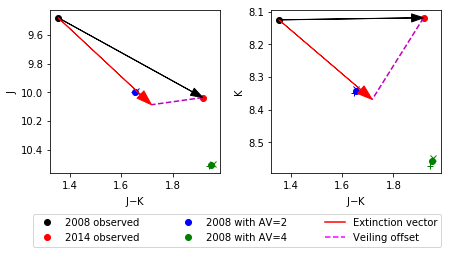

In [125]:
fig,[ax2,ax0]=plt.subplots(1,2,figsize=(7,3))

ax2.plot(mags1[2]-mags1[0],mags1[2],'ko')
ax2.plot(mags2[2]-mags2[0],mags2[2],'ro')
ax2.plot([mags2[2]-mags2[0],mags3[2]-mags3[0]],[mags2[2],mags3[2]],'--m')

ax0.plot(mags1[2]-mags1[0],mags1[0],'ko',label='2008 observed')
ax0.plot(mags2[2]-mags2[0],mags2[0],'ro',label='2014 observed')
ax0.plot([mags2[2]-mags2[0],mags3[2]-mags3[0]],[mags2[0],mags3[0]],'--m')

ax0.annotate("",xy=(mags2[2]-mags2[0],mags2[0]), xycoords='data',
            xytext=(mags1[2]-mags1[0],mags1[0]),textcoords='data',
            arrowprops=dict(color='black',headwidth=8,headlength=12,width=0.1))
ax0.annotate("",xy=(mags3[2]-mags3[0],mags3[0]), xycoords='data',
            xytext=(mags1[2]-mags1[0],mags1[0]),textcoords='data',
            arrowprops=dict(color='red',headwidth=10,headlength=15,width=0.1,linewidth=1))

ax2.annotate("",xy=(mags2[2]-mags2[0],mags2[2]), xycoords='data',
            xytext=(mags1[2]-mags1[0],mags1[2]),textcoords='data',
            arrowprops=dict(color='black',headwidth=8,headlength=12,width=0.1))
ax2.annotate("",xy=(mags3[2]-mags3[0],mags3[2]), xycoords='data',
            xytext=(mags1[2]-mags1[0],mags1[2]),textcoords='data',
            arrowprops=dict(color='red',headwidth=10,headlength=15,width=0.1,linewidth=1))

ax2.plot(mags1ext[0,2]-mags1ext[0,0],mags1ext[0,2],'+',color='blue')
ax2.plot(mags1ext[1,2]-mags1ext[1,0],mags1ext[1,2],'o',color='blue')
ax2.plot(mags1ext[2,2]-mags1ext[2,0],mags1ext[2,2],'x',color='blue')
ax2.plot(mags1ext[3,2]-mags1ext[3,0],mags1ext[3,2],'+',color='green')
ax2.plot(mags1ext[4,2]-mags1ext[4,0],mags1ext[4,2],'o',color='green')
ax2.plot(mags1ext[5,2]-mags1ext[5,0],mags1ext[5,2],'x',color='green')

ax0.plot(mags1ext[0,2]-mags1ext[0,0],mags1ext[0,0],'+',color='blue')
ax0.plot(mags1ext[1,2]-mags1ext[1,0],mags1ext[1,0],'o',color='blue',label='2008 with AV=2')
ax0.plot(mags1ext[2,2]-mags1ext[2,0],mags1ext[2,0],'x',color='blue')
ax0.plot(mags1ext[3,2]-mags1ext[3,0],mags1ext[3,0],'+',color='green')
ax0.plot(mags1ext[4,2]-mags1ext[4,0],mags1ext[4,0],'o',color='green',label='2008 with AV=4')
ax0.plot(mags1ext[5,2]-mags1ext[5,0],mags1ext[5,0],'x',color='green')


ax0.set_ylim(ax0.get_ylim()[::-1])
ax0.set_xlabel('J$-$K')
ax0.set_ylabel('K')

ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xlabel('J$-$K')
ax2.set_ylabel('J')
   
fig.subplots_adjust(wspace=0.3)

ax0.plot([],'red',label='Extinction vector')
ax0.plot([],'magenta',linestyle='dashed',label='Veiling offset')
ax0.plot([],'black',label='_Total',linewidth=3)

ax0.legend(bbox_to_anchor=(-1.40, -0.45, 2.4, 1.), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.0)


plt.show()

In [113]:
mags1

array([ 8.12545762,  8.63775381,  9.4796061 , 10.54233954, 11.57235532,
       12.84902046, 13.99366631])

In [114]:
mags2

array([ 8.1190166 ,  8.90018651, 10.03621318, 11.49856709, 12.84199828,
       14.84816432, 16.58947888])

In [115]:
mags3

array([ 8.3690166 ,  9.00018651, 10.08621318, 11.49856709, 12.84199828,
       14.84816432, 16.58947888])